In [1]:
import sklearn
print (sklearn.__version__)

0.21.2


In [2]:
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


In [3]:
df = pd.read_csv('loan.csv')
df.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


I did not get the original data, I have preprocessed data that has gone through following pre-processing:

- City variable dropped because of too many categories
- DOB converted to Age | DOB dropped
- EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0 | EMI_Loan_Submitted dropped
- EmployerName dropped because of too many categories
- Existing_EMI imputed with 0 (median) - 111 values were missing
- Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0 | Interest_Rate dropped
- Lead_Creation_Date dropped because made little intuitive impact on outcome
- Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
- Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped
- Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped
- LoggedIn, Salary_Account removed
- Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
- Source - top 2 kept as is and all others combined into different category
- Numerical and One-Hot-Coding performed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 51 columns):
Disbursed                        87020 non-null float64
Existing_EMI                     87020 non-null float64
ID                               87020 non-null object
Loan_Amount_Applied              87020 non-null float64
Loan_Tenure_Applied              87020 non-null float64
Monthly_Income                   87020 non-null int64
Var4                             87020 non-null int64
Var5                             87020 non-null int64
Age                              87020 non-null int64
EMI_Loan_Submitted_Missing       87020 non-null int64
Interest_Rate_Missing            87020 non-null int64
Loan_Amount_Submitted_Missing    87020 non-null int64
Loan_Tenure_Submitted_Missing    87020 non-null int64
Processing_Fee_Missing           87020 non-null int64
Device_Type_0                    87020 non-null float64
Device_Type_1                    87020 non-null float64
Filled_Form_0 

In [5]:
df['Disbursed'] = df['Disbursed'].apply(lambda x: round(x))
df.Disbursed.value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

In [6]:
target = 'Disbursed'
X = df.loc[:, df.columns!=target]
y = df.loc[:, df.columns==target]
X.drop('ID',axis=1,inplace=True)

Below we read in the data and separate into a training set and a "testing set". After creating the testing set, we cannot do any hyperparameter tuning with it! 

In [7]:
#Test train split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=3)

#### General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- Lower the learning rate and decide the optimal parameters .

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

- max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
- min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
- gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
- subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
- scale_pos_weight = 1: Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [8]:
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [9]:
predictors = X_train.columns
target = y_train.columns

In [10]:
xgb_param = xgb1.get_xgb_params()
xgb_param

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 0.8,
 'verbosity': 1}

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed

In [11]:
xgb1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

In [12]:
xgtrain = xgb.DMatrix(X_train.values,label=y_train.values)
xgtest = xgb.DMatrix(X_train.values)

#Cross-validation with given parameters.
cvresult = xgb.cv(xgb_param,xgtrain,num_boost_round=xgb_param['n_estimators'],nfold=5,metrics=['auc'],early_stopping_rounds=50)
print(cvresult.shape[0])

#Set the n_estimators with the count obtained from cv results
xgb1.set_params(n_estimators=cvresult.shape[0])

122


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=122, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [13]:
#Fit the algorithm on the data
xgb1.fit(X_train,y_train,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=122, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [14]:
#Predict training set
y_pred = xgb1.predict(X_train)
y_pred_proba = xgb1.predict_proba(X_train)[:,1]

#Print model report:
print ("\nModel Report")
print ("Accuracy : {:.4}".format(metrics.accuracy_score(y_train.values, y_pred)))
print ("AUC Score (Train): {:.4}".format( metrics.roc_auc_score(y_train, y_pred_proba)))


Model Report
Accuracy : 0.9852
AUC Score (Train): 0.9032


In [15]:
#Predict on testing data:
y_pred_test = xgb1.predict_proba(X_test)[:,1]

print ("AUC Score (Test): {:.4}".format( metrics.roc_auc_score(y_test, y_pred_test)))

AUC Score (Test): 0.8496


Text(0,0.5,'Feature Importance Score')

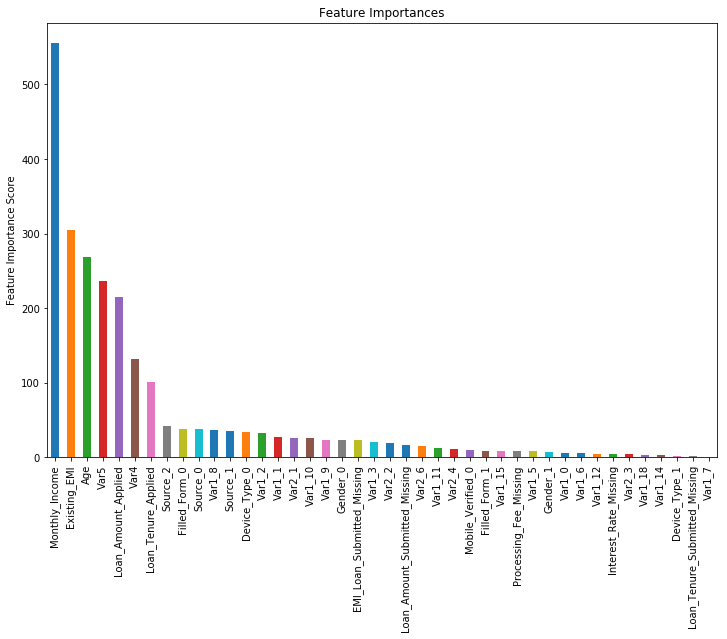

In [16]:
plt.figure(figsize=(12,8))
feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Lets create a generic function to 
- update n_estimators with cv function of xgboost package
- fit the model
- determine training accuracy
- determine training AUC
- determine testing AUC
- plot Feature Importance

In [17]:
def modelfit(alg, X_train, X_test, y_train, y_test ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV is True:
        xgb_param = alg.get_xgb_params()
        
        xgtrain = xgb.DMatrix(X_train.values,label=y_train.values)
        xgtest = xgb.DMatrix(X_train.values)

        #Cross-validation with given parameters.
        cvresult = xgb.cv(xgb_param,xgtrain,num_boost_round=xgb_param['n_estimators'],
                          nfold=cv_folds,metrics=['auc'],early_stopping_rounds=early_stopping_rounds)

        #Set the n_estimators with the count obtained from cv results
        alg.set_params(n_estimators=cvresult.shape[0])
        print("Best estimators : ", cvresult.shape[0])
        
    #Fit the algorithm on the data
    alg.fit(X_train,y_train,eval_metric='auc')
        
    #Predict training set
    y_pred = xgb1.predict(X_train)
    y_pred_proba = xgb1.predict_proba(X_train)[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : {:.4}".format(metrics.accuracy_score(y_train.values, y_pred)))
    print ("AUC Score (Train): {:.4}".format( metrics.roc_auc_score(y_train, y_pred_proba)))
    
    #Predict on testing data:
    y_pred_test = alg.predict_proba(X_test)[:,1]

    print ("AUC Score (Test): {:.4}".format( metrics.roc_auc_score(y_test, y_pred_test)))
    
    plt.figure(figsize=(12,8))
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Best estimators :  122

Model Report
Accuracy : 0.9852
AUC Score (Train): 0.9032
AUC Score (Test): 0.8496


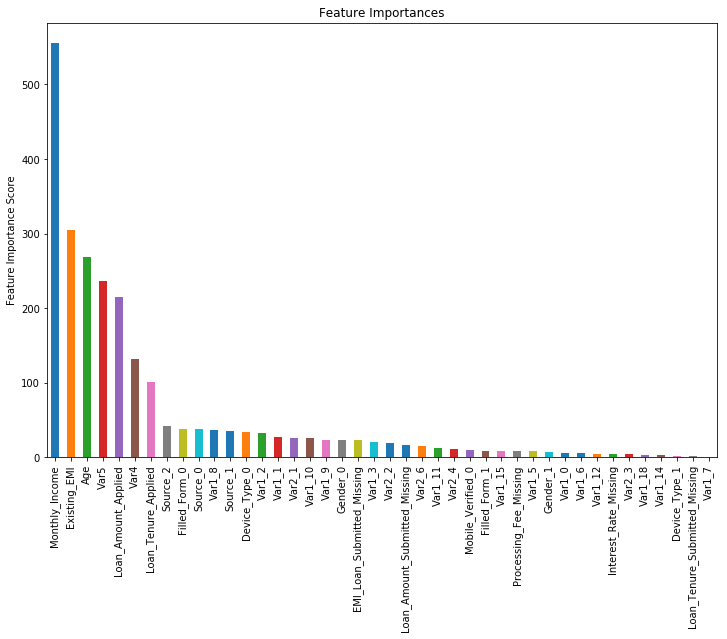

In [18]:
modelfit(xgb1, X_train, X_test, y_train, y_test)

As you can see that here we got 122 as the optimal estimators for 0.1 learning rate. Note that if this value is too high depending on the power of the system. In that case you can increase the learning rate and re-run the command to get the reduced number of estimators.

### Step 2: Tune max_depth and min_child_weight

Next, we tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [19]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(2,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=122, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train.values.ravel())

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([28.09563828, 30.19628987, 45.95246177, 38.59872284, 51.39477935,
         54.32691808, 70.90218554, 60.88766313]),
  'std_fit_time': array([0.41398842, 1.92655163, 5.52982946, 0.53286101, 2.4352441 ,
         0.33618002, 2.85659457, 9.02185049]),
  'mean_score_time': array([0.14329948, 0.1733849 , 0.16805773, 0.14608951, 0.15471058,
         0.14879541, 0.17827444, 0.19000983]),
  'std_score_time': array([0.03059654, 0.02602753, 0.02997597, 0.01503105, 0.01488749,
         0.02143733, 0.03369914, 0.02819897]),
  'param_max_depth': masked_array(data=[3, 3, 5, 5, 7, 7, 9, 9],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 4, 2, 4, 2, 4, 2, 4],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 3, 'min_child_weight': 2},
   

In [21]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=122, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train.values.ravel())
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([41.2236196 , 37.52606568, 36.23579612, 45.7104486 , 42.99876862,
         52.38587809, 55.6586277 , 49.89665031, 46.16236486]),
  'std_fit_time': array([1.40308246, 0.31431185, 1.0112621 , 0.79134902, 1.65116344,
         6.11491012, 8.83107675, 1.84429376, 6.93019253]),
  'mean_score_time': array([0.18679624, 0.14057503, 0.14238   , 0.16413975, 0.17556543,
         0.21547408, 0.17977614, 0.17626548, 0.15793142]),
  'std_score_time': array([0.05008836, 0.01273272, 0.03113136, 0.04064467, 0.04741351,
         0.02400691, 0.06316905, 0.05783636, 0.02904099]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],


### Step 3 : Tune gamma

In [22]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=122, max_depth=5,
 min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,y_train.values.ravel())
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([47.95003557, 55.47046037, 52.4488605 , 49.1966135 , 41.67743168]),
  'std_fit_time': array([ 5.0591445 ,  3.31573005,  0.77826038,  1.42131202, 11.93673199]),
  'mean_score_time': array([0.17988091, 0.15631762, 0.19622254, 0.1666914 , 0.18218446]),
  'std_score_time': array([0.0414344 , 0.02664942, 0.04141347, 0.03076848, 0.12195459]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.82710178, 0.82539914, 0.82487526, 0.82498321, 0.8230962 ]),
  'split1_test_score': array([0.83710224, 0.83831956, 0.83556249, 0.83661217, 0.83736356]),
  'split2_test_score': array([0.86481936, 0.86490142, 0.86534292, 0.86626377, 0.86628543]),
  'split3_test_score': array([0.84575262, 0.84536431, 0.84624748, 0.84358213, 0.8

### Step 4 : Tune subsample and colsample_bytree

In [23]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=122, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8408008068095283)

### Step 5: Tuning Regularization Parameters

In [24]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols (1e-5 : 0.00001)
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=122, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train.values.ravel())
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.8408009476834184)

Best estimators :  122

Model Report
Accuracy : 0.9852
AUC Score (Train): 0.9032
AUC Score (Test): 0.8496


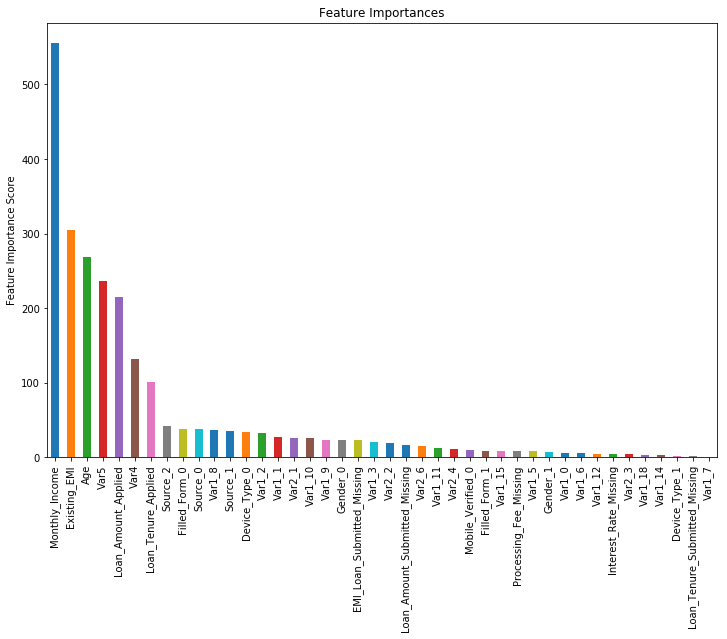

In [25]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, X_train, X_test, y_train, y_test)

### Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.
Normally, we decrease the learning rate to half, i.e. 0.05 and with twice the number of trees.

Best estimators :  258

Model Report
Accuracy : 0.9852
AUC Score (Train): 0.9032
AUC Score (Test): 0.85


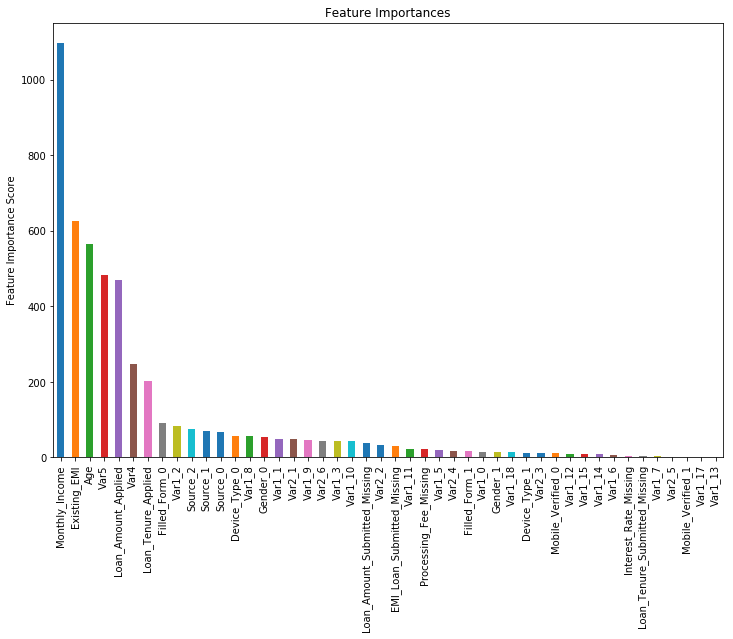

In [29]:
xgb3 = XGBClassifier(
        learning_rate =0.05,
        n_estimators=5000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, y_train, y_test)